In [0]:
class NoiseRegularizer(object):
    def __init__(self, discrete_dims, h, cuda):
        self.h = h
        self.discrete_dims = discrete_dims
        self.cuda = cuda

    def add_noise(self, z):
        noise_dist = self._create_noise_dist(z)
        xi = noise_dist.sample()
        z_hat = z + self.h * xi
        return z_hat

    def _create_noise_dist(self, z):
        means = torch.zeros(z.shape)
        scales = torch.ones(z.shape)

        # Set scale to 0 to avoid adding noise to discrete dims
        if self.discrete_dims is not None:
            for dim in self.discrete_dims:
                scales[:, dim] = 0

        if self.cuda:
            noise_dist = dist.Normal(means.cuda(), scales.cuda())
        else:
            noise_dist = dist.Normal(means, scales)

        return noise_dist

# Plot notebook

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Circle transform plot

In [0]:
def circle_transform(z, max_val):
    x_val = np.cos(2*np.pi*z/max_val)
    y_val = np.sin(2*np.pi*z/max_val)
    return x_val, y_val

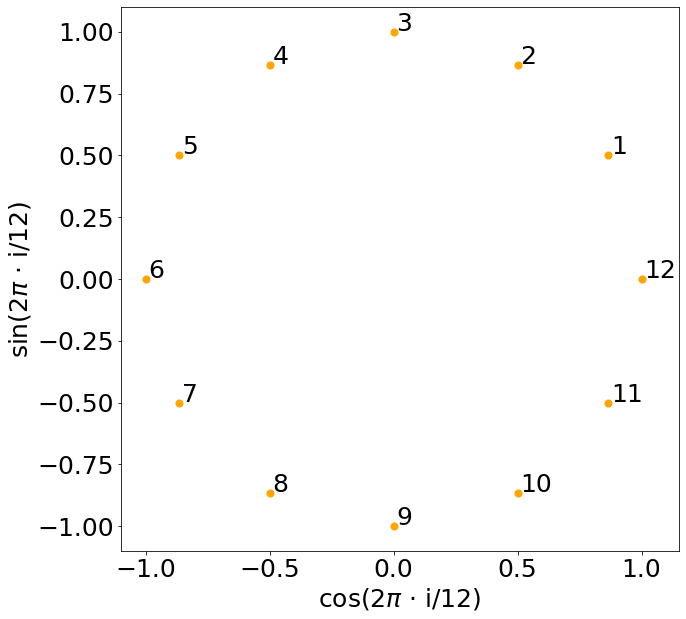

In [48]:
coordinates = []
max_val = 12
numbers = range(1,max_val + 1)
for i in numbers:
    x_val, y_val = circle_transform(i,max_val)
    coordinates.append([x_val, y_val])
coordinates = np.array(coordinates)

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
ax.scatter(coordinates[:,0], coordinates[:,1], s=50, c = 'orange')

for i in range(max_val):
    ax.annotate(i+1, xy = (coordinates[i,0], coordinates[i,1]), xytext=(3,1), textcoords='offset pixels', fontsize=25)

ax.set_xlabel("cos(2$\pi$ $\cdot$ i/12)", fontsize=25)
ax.set_ylabel("sin(2$\pi$ $\cdot$ i/12)", fontsize=25)
ax.set_xlim((-1.1, 1.15))
ax.tick_params(axis='both', which='major', labelsize=25)

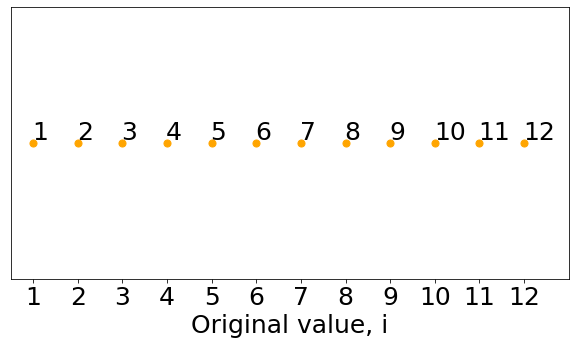

In [52]:
coordinates = []
max_val = 12
numbers = range(1,max_val + 1)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(numbers, np.zeros(max_val), s=50, c = 'orange')

for i in range(max_val):
    ax.annotate(i+1, xy = (numbers[i], np.zeros(max_val)[i]), xytext=(-1,3), textcoords='offset pixels', fontsize=25)

ax.set_xlabel("Original value, i", fontsize=25)
ax.set_xticks(range(1,13))
ax.set_yticks([])
ax.set_xlim((0.5,13))
ax.tick_params(axis='both', which='major', labelsize=25)

# Check use of noisereg

In [6]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 2.8MB/s 


In [0]:
import torch
import pyro.distributions as dist

def mod_circle_transform(z, max_val):
    x_val = np.cos(2*np.pi*z/max_val)
    y_val = np.sin(2*np.pi*z/max_val)
    return torch.tensor([x_val, y_val])

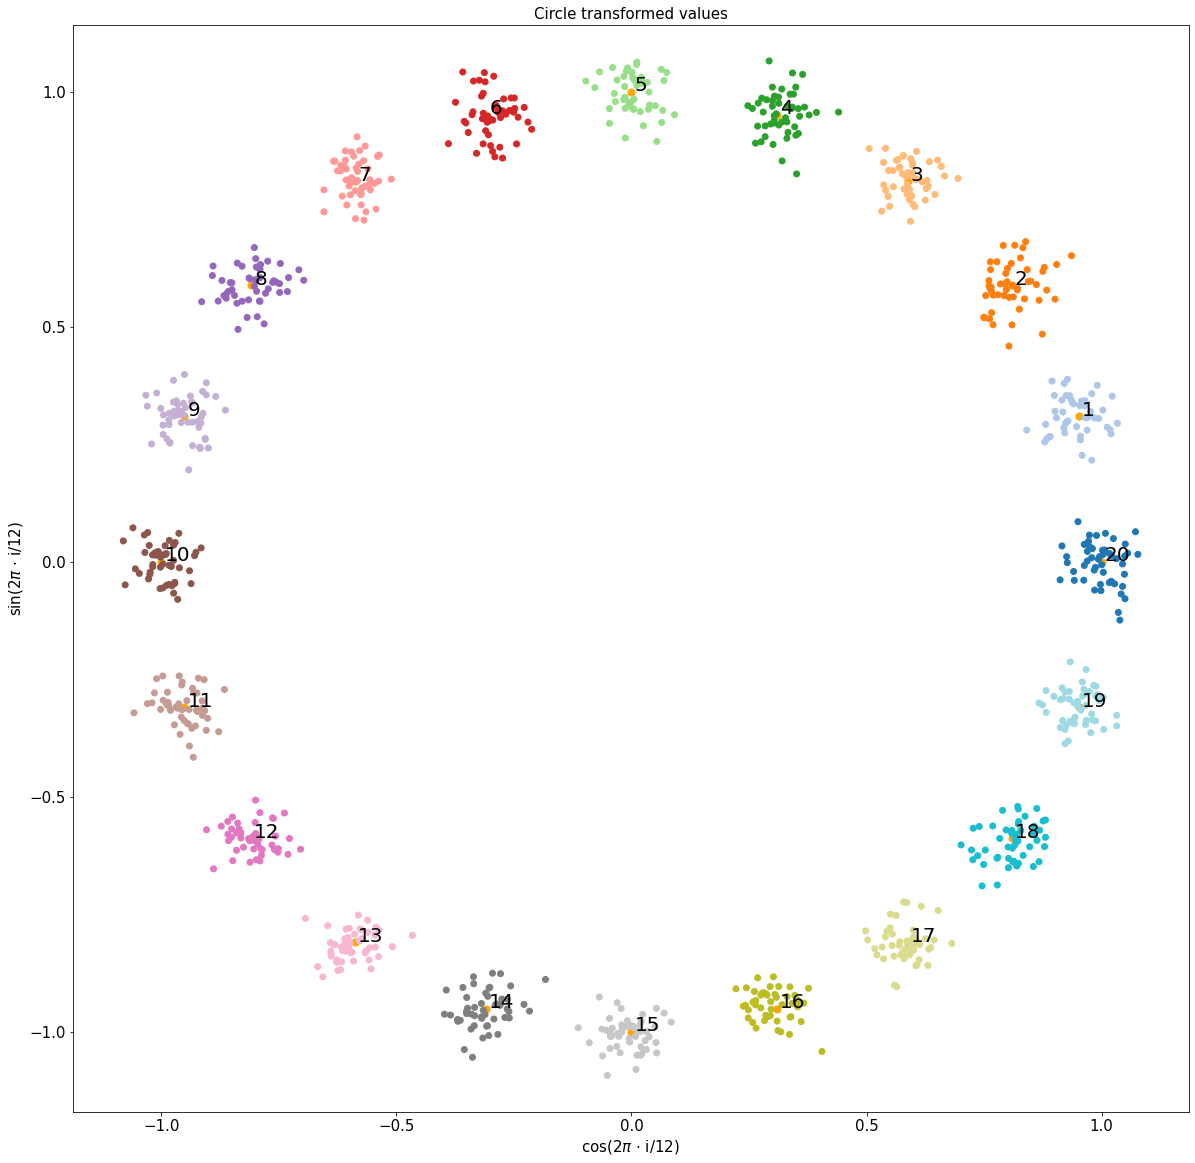

In [8]:
noise_reg = NoiseRegularizer(None, 0.04, False)

values = [i%20 for i in range(1000)]

circle_values = [mod_circle_transform(i,20) for i in values]


reg_circ_values = [noise_reg.add_noise(point) for point in circle_values]
reg_circ_values = torch.stack(reg_circ_values)

coordinates = []
max_val = 20
numbers = range(1,max_val + 1)
for i in numbers:
    x_val, y_val = circle_transform(i,max_val)
    coordinates.append([x_val, y_val])
coordinates = np.array(coordinates)

fig, ax = plt.subplots(figsize=(20,20))
ax.axis('equal')
ax.scatter(coordinates[:,0], coordinates[:,1], s=50, c = 'orange')

for i in range(max_val):
    ax.annotate(i+1, xy = (coordinates[i,0], coordinates[i,1]), xytext=(3,1), textcoords='offset pixels', fontsize=20)


ax.set_title('Circle transformed values', fontsize=15)
ax.set_xlabel("cos(2$\pi$ $\cdot$ i/12)", fontsize=15)
ax.set_ylabel("sin(2$\pi$ $\cdot$ i/12)", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(reg_circ_values[:,0], reg_circ_values[:,1], c=values, cmap = 'tab20')

Itertools tests

In [0]:
import itertools

In [0]:
flow_depth = 8

In [0]:
affine_couplings = [f"ac_{i}" for i in range(flow_depth // 2)]
planars = [f"planar_{i}" for i in range(flow_depth // 2)]
perms = [f"perm_{i}" for i in range(flow_depth // 2)]
batchnorms = [f"bn_{i}" for i in range(flow_depth)]

In [0]:
no_bn_flow = list(itertools.chain(*zip(planars, affine_couplings, perms)))[:-1]

In [13]:
no_bn_flow

['planar_0',
 'ac_0',
 'perm_0',
 'planar_1',
 'ac_1',
 'perm_1',
 'planar_2',
 'ac_2',
 'perm_2',
 'planar_3',
 'ac_3']

In [0]:
bn_flow = no_bn_flow[:1]
k = 0
batchnorms = []
for i, trans in enumerate(no_bn_flow[1:]):
    if 'ac' in trans or 'planar' in trans:
        batchnorms.append(f"batchnorm_{k}")
        bn_flow.append(batchnorms[-1])
        k+=1
    bn_flow.append(trans)

In [15]:
type(bn_flow) is list

True

In [16]:
isinstance(bn_flow, list)

True

In [17]:
bn_flow

['planar_0',
 'batchnorm_0',
 'ac_0',
 'perm_0',
 'batchnorm_1',
 'planar_1',
 'batchnorm_2',
 'ac_1',
 'perm_1',
 'batchnorm_3',
 'planar_2',
 'batchnorm_4',
 'ac_2',
 'perm_2',
 'batchnorm_5',
 'planar_3',
 'batchnorm_6',
 'ac_3']

In [18]:
list(itertools.chain(*zip(affine_couplings, planars, perms)))[:-1]

['ac_0',
 'planar_0',
 'perm_0',
 'ac_1',
 'planar_1',
 'perm_1',
 'ac_2',
 'planar_2',
 'perm_2',
 'ac_3',
 'planar_3']

In [19]:
'perm' in perms[0]

True

In [20]:
bn_flow


['planar_0',
 'batchnorm_0',
 'ac_0',
 'perm_0',
 'batchnorm_1',
 'planar_1',
 'batchnorm_2',
 'ac_1',
 'perm_1',
 'batchnorm_3',
 'planar_2',
 'batchnorm_4',
 'ac_2',
 'perm_2',
 'batchnorm_5',
 'planar_3',
 'batchnorm_6',
 'ac_3']

In [21]:
no_bn_flow

['planar_0',
 'ac_0',
 'perm_0',
 'planar_1',
 'ac_1',
 'perm_1',
 'planar_2',
 'ac_2',
 'perm_2',
 'planar_3',
 'ac_3']

In [22]:
bn_flow + no_bn_flow

['planar_0',
 'batchnorm_0',
 'ac_0',
 'perm_0',
 'batchnorm_1',
 'planar_1',
 'batchnorm_2',
 'ac_1',
 'perm_1',
 'batchnorm_3',
 'planar_2',
 'batchnorm_4',
 'ac_2',
 'perm_2',
 'batchnorm_5',
 'planar_3',
 'batchnorm_6',
 'ac_3',
 'planar_0',
 'ac_0',
 'perm_0',
 'planar_1',
 'ac_1',
 'perm_1',
 'planar_2',
 'ac_2',
 'perm_2',
 'planar_3',
 'ac_3']